In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


train = pd.read_csv("/kaggle/input/dataenc/dataEnc/imagesDataEncodedTrain")
validation = pd.read_csv("/kaggle/input/dataenc/dataEnc/imagesDataEncodedVal")
testing = pd.read_csv("/kaggle/input/dataenc/dataEnc/imagesDataEncodedTest")

trainArray = np.array(train)
validationArray = np.array(validation)
testingArray = np.array(testing)


np.random.shuffle(trainArray)
np.random.shuffle(validationArray) # shuffle before splitting into dev and training sets
np.random.shuffle(testingArray) 

class MLP:
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.params = {
            'W1': np.random.randn(inputSize, hiddenSize) * np.sqrt(1. / inputSize),
            'b1': np.zeros((1, hiddenSize)),
            'W2': np.random.randn(hiddenSize, outputSize) * np.sqrt(1. / hiddenSize),
            'b2': np.zeros((1, outputSize))
        }
        self.outputSize = outputSize

    def relu(self, x):
        return np.maximum(0, x)

    def reluDerivative(self, x):
        return x > 0

    def softmax(self, x):
        eX = np.exp(x - np.max(x, axis=1, keepdims=True))
        return eX / np.sum(eX, axis=1, keepdims=True)

    def oneHotEncode(self, labels):
        oneHot = np.zeros((labels.size, self.outputSize))
        oneHot[np.arange(labels.size), labels] = 1
        return oneHot

    def forwardPass(self, X):
        z1 = X.dot(self.params['W1']) + self.params['b1']
        a1 = self.relu(z1)
        z2 = a1.dot(self.params['W2']) + self.params['b2']
        a2 = self.softmax(z2)
        self.cache = {'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
        return a2

    def computeLoss(self, Y, output):
        m = Y.shape[0]
        logLikelihood = -np.log(output[range(m), Y.argmax(axis=1)])
        loss = np.sum(logLikelihood) / m
        return loss

    def backwardPass(self, X, Y):
        m = X.shape[0]
        output = self.cache['a2']
        da2 = output - Y
        dW2 = self.cache['a1'].T.dot(da2) / m
        db2 = np.sum(da2, axis=0, keepdims=True) / m
        
        da1 = da2.dot(self.params['W2'].T)
        dz1 = da1 * self.reluDerivative(self.cache['z1'])
        dW1 = X.T.dot(dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return grads

    def updateParameters(self, grads, learningRate):
        self.params['W1'] -= learningRate * grads['dW1']
        self.params['b1'] -= learningRate * grads['db1']
        self.params['W2'] -= learningRate * grads['dW2']
        self.params['b2'] -= learningRate * grads['db2']

    def train(self, XTrain, YTrainIntegers, XVal, YValIntegers, epochs, learningRate, patience):
        YTrain = self.oneHotEncode(YTrainIntegers)
        YVal = self.oneHotEncode(YValIntegers)
        bestLoss = np.inf
        patienceCounter = 0

        trainLosses = []
        valLosses = []
        trainAccuracies = []
        valAccuracies = []
        
        for epoch in range(epochs):
            output = self.forwardPass(XTrain)
            loss = self.computeLoss(YTrain, output)
            grads = self.backwardPass(XTrain, YTrain)
            self.updateParameters(grads, learningRate)
            valOutput = self.forwardPass(XVal)
            valLoss = self.computeLoss(YVal, valOutput)
            trainAccuracy = np.mean(np.argmax(output, axis=1) == YTrainIntegers)
            valAccuracy = np.mean(np.argmax(valOutput, axis=1) == YValIntegers)
            trainLosses.append(loss)
            valLosses.append(valLoss)
            trainAccuracies.append(trainAccuracy)
            valAccuracies.append(valAccuracy)
            
            if valLoss < bestLoss:
                bestLoss = valLoss
                patienceCounter = 0
            else:
                patienceCounter += 1
                if patienceCounter >= patience:
                    print(f'Stopping early at epoch {epoch + 1}')
                    break

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch + 1}, Train Loss: {loss:.4f}, Validation Loss: {valLoss:.4f}, Train Accuracy: {trainAccuracy:.4f}, Validation Accuracy: {valAccuracy:.4f}')

        '''plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(trainLosses, label='Train Loss')
        plt.plot(valLosses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(trainAccuracies, label='Train Accuracy')
        plt.plot(valAccuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.show()'''

    def evaluate(self, XTest, YTestIntegers):
        YTest = self.oneHotEncode(YTestIntegers)
        output = self.forwardPass(XTest)
        testLoss = self.computeLoss(YTest, output)
        predictions = np.argmax(output, axis=1)
        accuracy = np.mean(predictions == YTestIntegers)
        cm = confusion_matrix(YTestIntegers, predictions)
        classReport = classification_report(YTestIntegers, predictions)
        return testLoss, accuracy, cm, classReport


xTrain = trainArray[:, 1:] # Features are all columns except the first one (class column), and transpose to match MLP input format
yTrain = trainArray[:, 0]
xVal = validationArray[:, 1:]  # Features are all columns except the first one (class column), and transpose to match MLP input format
yVal = validationArray[:, 0]
xTest = testingArray[:, 1:] # Features are all columns except the first one (class column), and transpose to match MLP input format
yTest = testingArray[:, 0]

yTrain = yTrain.astype(int)
yVal = yVal.astype(int)
yTest = yTest.astype(int)


inputSize = 2304  
hiddenSize = 150  
outputSize = 7  
mlp = MLP(inputSize, hiddenSize, outputSize)

epochs = 200
learningRate = 0.01
patience = 10 
mlp.train(xTrain, yTrain, xVal, yVal, epochs, learningRate, patience)

testLoss, accuracy, cm, classReport = mlp.evaluate(xTest, yTest)
print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")
print("Confusion Matrix:")
print(cm)
print(classReport)


Epoch 1, Train Loss: 2.0702, Validation Loss: 1.9454, Train Accuracy: 0.1531, Validation Accuracy: 0.2223
Epoch 101, Train Loss: 1.7907, Validation Loss: 1.9394, Train Accuracy: 0.2576, Validation Accuracy: 0.2510
Epoch 200, Train Loss: 1.7676, Validation Loss: 1.9371, Train Accuracy: 0.2779, Validation Accuracy: 0.1682
Test Loss: 1.7735
Test Accuracy: 27.51%
Confusion Matrix:
[[   0    4    2    3    1   99    2]
 [   0   42   35   44    7  840   56]
 [   0   30   84   31    1  639   46]
 [   0   40   17  103    7 1017   63]
 [   0   37   31   54    6  793   37]
 [   0   33   10   32   10 1637   52]
 [   0   28   17   42    7 1036  103]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.20      0.04      0.07      1024
           2       0.43      0.10      0.16       831
           3       0.33      0.08      0.13      1247
           4       0.15      0.01      0.01       958
           5       0.27     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: module 'matplotlib.pyplot' has no attribute 'tight_paint'

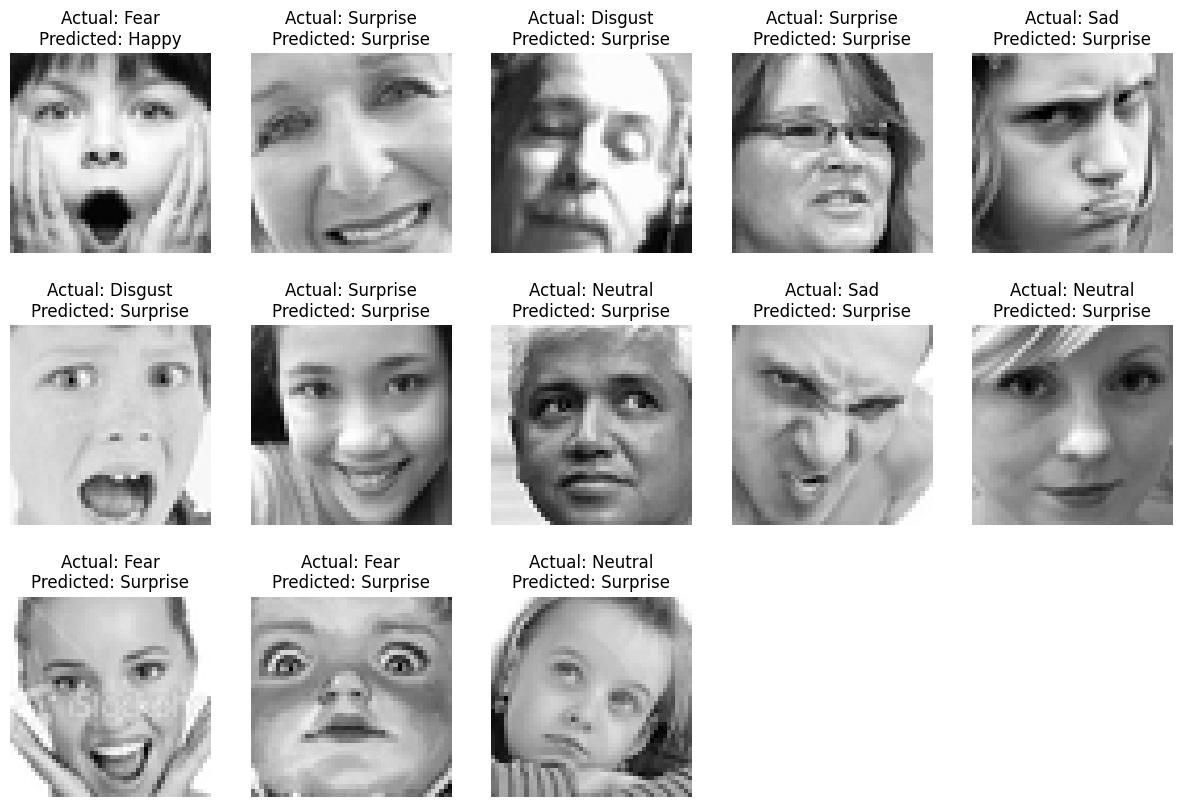

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(images, actual_labels, predicted_labels, index_to_class):
    plt.figure(figsize=(15, 10))  # Adjusted for better display of 13 images
    indices = np.random.choice(images.shape[0], size=13, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i + 1)  # Adjust layout to fit all images nicely
        plt.imshow(images[idx].reshape(48, 48), cmap='gray')  # Assuming images are 48x48 pixels
        plt.title(f"Actual: {index_to_class[actual_labels[idx]]}\nPredicted: {index_to_class[predicted_labels[idx]]}")
        plt.axis('off')
    plt.tight_paint()
    plt.show()

# Assuming you have a way to map from indices to class names
index_to_class = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Call the function after evaluating the model
test_output = mlp.forwardPass(xTest)
predicted_labels = np.argmax(test_output, axis=1)
display_sample_images(xTest, yTest, predicted_labels, index_to_class)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.fc1 = nn.Linear(48*48, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 7)  
    def forward(self, x):
        x = x.view(-1, 48*48)  
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

model = MyDNN().to(device)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

train = ImageFolder(root='/kaggle/input/dataunenc/dataUnEnc/train', transform=transform)
test= ImageFolder(root='/kaggle/input/dataunenc/dataUnEnc/test', transform=transform)

trainSize = int(0.8 * len(train))
valSize = len(train) - trainSize
train, val = random_split(train, [trainSize, valSize])
trainLoader = DataLoader(train, batch_size=16, shuffle=True)
valLoader = DataLoader(val, batch_size=16, shuffle=False)
testLoader = DataLoader(test, batch_size=16, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


numEpochs = 300
trainLosses = []
trainAccuracies = []
valLosses = []
valAccuracies = []
valPrecisions = []
valRecalls = []
valAccuracies = []

patience = 10  
minDelta = 0.001 
bestValLoss = float('inf')
counter = 0

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0
    correctTrain = 0
    totalTrain = 0
    
    
    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        totalTrain += labels.size(0)
        correctTrain += (predicted == labels).sum().item()
    
    trainLoss = runningLoss / len(trainLoader)
    trainAccuracy = correctTrain / totalTrain
    trainLosses.append(trainLoss)
    trainAccuracies.append(trainAccuracy)
    
  
    model.eval()
    runningLoss = 0.0
    correctVal = 0
    totalVal = 0
    allPredictions = []
    allLabels = []
    
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            runningLoss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            totalVal += labels.size(0)
            correctVal += (predicted == labels).sum().item()
            
            allPredictions.extend(predicted.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())
    
    valLoss = runningLoss / len(valLoader)
    valAccuracy = correctVal / totalVal
    valPrecision = precision_score(allLabels, allPredictions, average='macro')
    valRecall = recall_score(allLabels, allPredictions, average='macro')
    valAccuracy = accuracy_score(allLabels, allPredictions)

    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)
    valPrecisions.append(valPrecision)
    valRecalls.append(valRecall)
    
    print(f"Epoch {epoch+1}/{numEpochs}, Train Loss: {trainLoss:.4f}, Train Acc: {trainAccuracy:.4f}")
    
    if valLoss < bestValLoss - minDelta:
        bestValLoss = valLoss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break
'''
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()'''

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/300, Train Loss: 1.7112, Train Acc: 0.3164


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/300, Train Loss: 1.6358, Train Acc: 0.3583


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/300, Train Loss: 1.5973, Train Acc: 0.3732


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/300, Train Loss: 1.5602, Train Acc: 0.3933


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/300, Train Loss: 1.5261, Train Acc: 0.4085


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/300, Train Loss: 1.4891, Train Acc: 0.4247


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/300, Train Loss: 1.4576, Train Acc: 0.4385
Epoch 8/300, Train Loss: 1.4263, Train Acc: 0.4536
Epoch 9/300, Train Loss: 1.3908, Train Acc: 0.4702
Epoch 10/300, Train Loss: 1.3546, Train Acc: 0.4836
Epoch 11/300, Train Loss: 1.3197, Train Acc: 0.4993
Epoch 12/300, Train Loss: 1.2874, Train Acc: 0.5123
Epoch 13/300, Train Loss: 1.2482, Train Acc: 0.5325
Epoch 14/300, Train Loss: 1.2129, Train Acc: 0.5484
Epoch 15/300, Train Loss: 1.1788, Train Acc: 0.5619
Epoch 16/300, Train Loss: 1.1370, Train Acc: 0.5754
Epoch 17/300, Train Loss: 1.1045, Train Acc: 0.5876
Epoch 18/300, Train Loss: 1.0644, Train Acc: 0.6062
Early stopping triggered. No improvement in validation loss.


"\nplt.figure(figsize=(10, 5))\nplt.subplot(1, 2, 1)\nplt.plot(train_losses, label='Train Loss')\nplt.plot(val_losses, label='Val Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss')\nplt.legend()\n\nplt.subplot(1, 2, 2)\nplt.plot(train_accuracies, label='Train Accuracy')\nplt.plot(val_accuracies, label='Val Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.title('Training and Validation Accuracy')\nplt.legend()\n\nplt.show()"

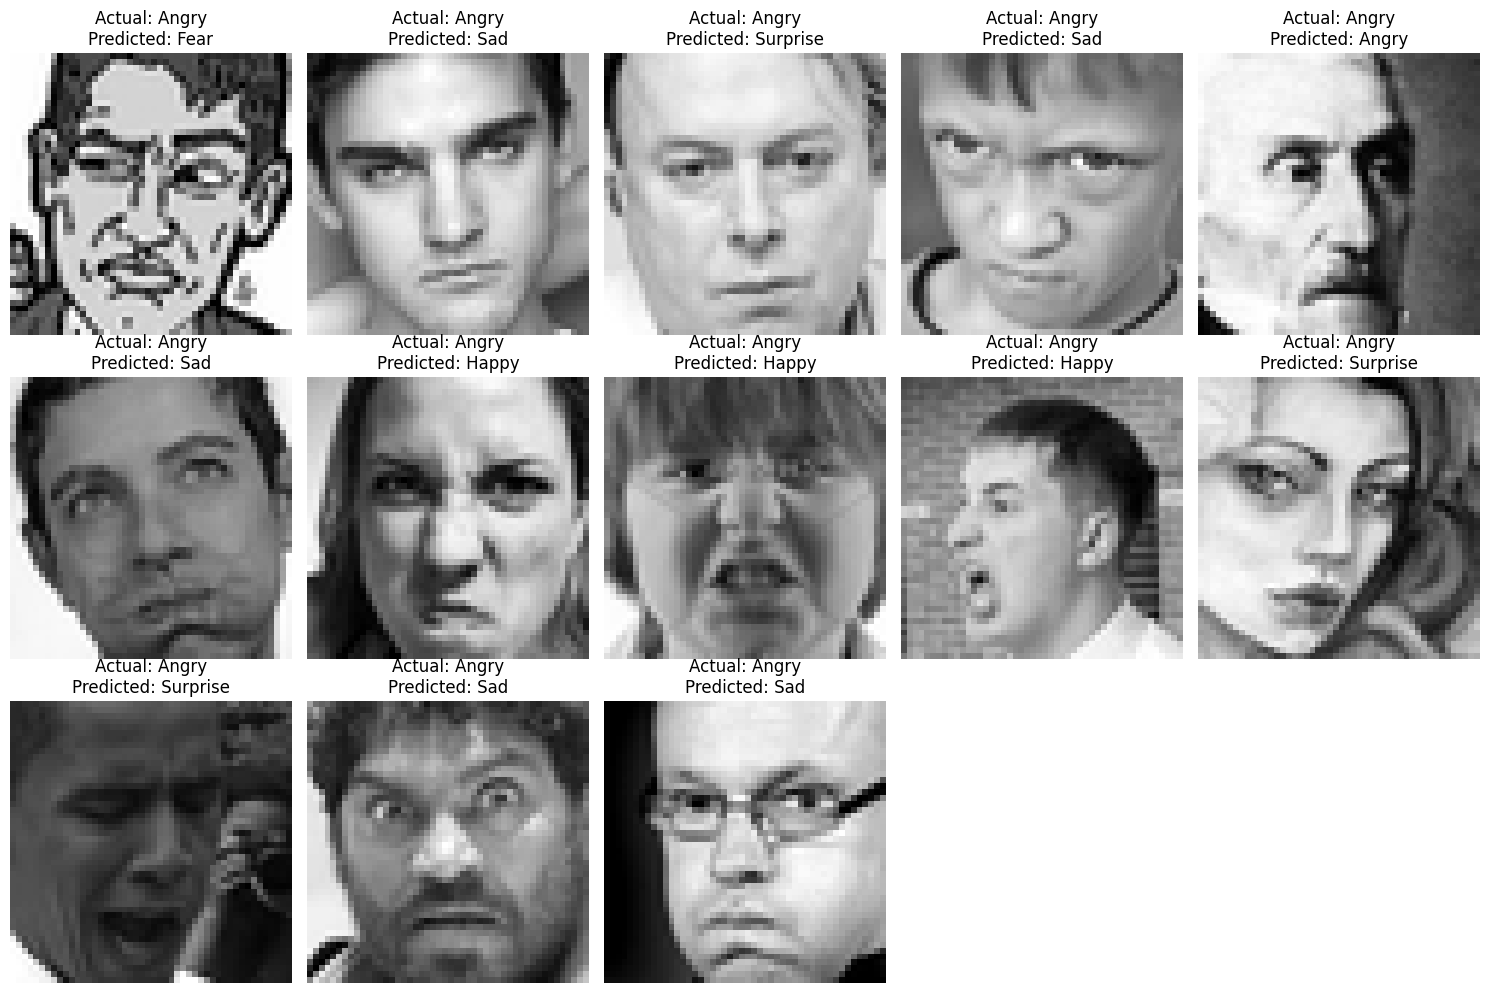

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def display_images_and_predictions(loader, model, device, classes, num_images=13):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(loader))  # Get one batch of images and labels
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Get the predicted class indices

    # Shuffle the images and labels in the batch
    indices = torch.randperm(len(labels))[:num_images]  # Generate random permutation of indices and select the first 'num_images'
    images, labels, predicted = images[indices], labels[indices], predicted[indices]

    images = images.cpu().numpy()  
    labels = labels.cpu().numpy()  
    predicted = predicted.cpu().numpy()  
    plt.figure(figsize=(15, 10))  
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)  
        img = images[i].squeeze()  
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {classes[labels[i]]}\nPredicted: {classes[predicted[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


display_images_and_predictions(testLoader, model, device, class_names, num_images=13)


In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix


train_dir = '/kaggle/input/dataunenc/dataUnEnc/train'
test_dir = '/kaggle/input/dataunenc/dataUnEnc/test'

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,horizontal_flip=True,validation_split=0.2 )
training_set = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(48, 48),shuffle=True,color_mode='grayscale',class_mode='categorical',subset='training' )
validation_set = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(48, 48),shuffle=True,color_mode='grayscale',class_mode='categorical',subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(48, 48),shuffle=True,color_mode='grayscale',class_mode='categorical')


def get_model(input_size, classes=7):
    model = tf.keras.models.Sequential()

   
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    # Add a batch normalization layer
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
   
    model.add(BatchNormalization())
   
    model.add(MaxPooling2D(pool_size=(2, 2)))
  

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
   
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add a dense layer with 256 neurons and relu activation function
    model.add(Dense(256, activation='relu'))
    # Add a seventh batch normalization layer
    model.add(BatchNormalization())
    # Add a dropout layer with 0.5 dropout rate
    model.add(Dropout(0.5))
    # Add a dense layer with 7 neurons (one for each class) and softmax activation function
    model.add(Dense(7, activation='softmax'))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

fernet = get_model((48, 48, 1), 7)


chk_path = 'model/orasModel.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True, verbose=1, mode='max', monitor='accuracy')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, tensorboard_callback, csv_logger, early_stopping]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=500,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

2024-05-27 12:11:00.892853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 12:11:00.892945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 12:11:01.024511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/500


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-27 12:11:48.052357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 764: 1.02572, expected 0.811342
2024-05-27 12:11:48.052404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 811: 1.06854, expected 0.85416
2024-05-27 12:11:48.052413: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 812: 1.14172, expected 0.927341
2024-05-27 12:11:48.052421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 909: 1.06408, expected 0.849701
2024-05-27 12:11:48.052430: E external/local_xla/xla/service/gpu/buffer_compa

  1/717 ━━━━━━━━━━━━━━━━━━━━ 3:35:04 18s/step - accuracy: 0.1250 - loss: 3.2667

I0000 00:00:1716811917.474607     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-27 12:11:59.878829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.07344, expected 3.39204
2024-05-27 12:11:59.878889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.66488, expected 2.98347
2024-05-27 12:11:59.878899: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.34272, expected 2.66131
2024-05-27 12:11:59.878906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.82969, expected 3.14828
2024-05-27 12:11:59.878914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.0197, expected 2.33829
2024-05-27 12:11:59.878922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.8467, expected 2.16529
2024-05-27 12:11:59.878929: E extern

717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1901 - loss: 2.7657

2024-05-27 12:14:03.968535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2116: 3.2693, expected 2.35357
2024-05-27 12:14:03.968593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2117: 2.94205, expected 2.02631
2024-05-27 12:14:03.968608: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2118: 3.30363, expected 2.3879
2024-05-27 12:14:03.968621: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2119: 3.37876, expected 2.46302
2024-05-27 12:14:03.968632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2120: 2.38085, expected 1.46511
2024-05-27 12:14:03.968642: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2121: 2.83428, expected 1.91855
2024-05-27 12:14:03.968652: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2122: 3.02836, expected 2.11263
2024-05-27 12:14:03.968663: E extern


Epoch 1: accuracy improved from -inf to 0.20344, saving model to model/orasModel.keras


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


717/717 ━━━━━━━━━━━━━━━━━━━━ 146s 179ms/step - accuracy: 0.1901 - loss: 2.7655 - val_accuracy: 0.3207 - val_loss: 1.7848
Epoch 2/500
  1/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1562 - loss: 2.6845
Epoch 2: accuracy did not improve from 0.20344
717/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1562 - loss: 2.6845 - val_accuracy: 0.3257 - val_loss: 1.7789
Epoch 3/500
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2477 - loss: 2.2866
Epoch 3: accuracy improved from 0.20344 to 0.25780, saving model to model/orasModel.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.2477 - loss: 2.2864 - val_accuracy: 0.3642 - val_loss: 1.6798
Epoch 4/500
  1/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2812 - loss: 2.2892
Epoch 4: accuracy improved from 0.25780 to 0.28125, saving model to model/orasModel.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2812 - loss: 2.2892 - val_accuracy: 0.3640 - val_loss: 1.6850
Epoch 5/500
713/717 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


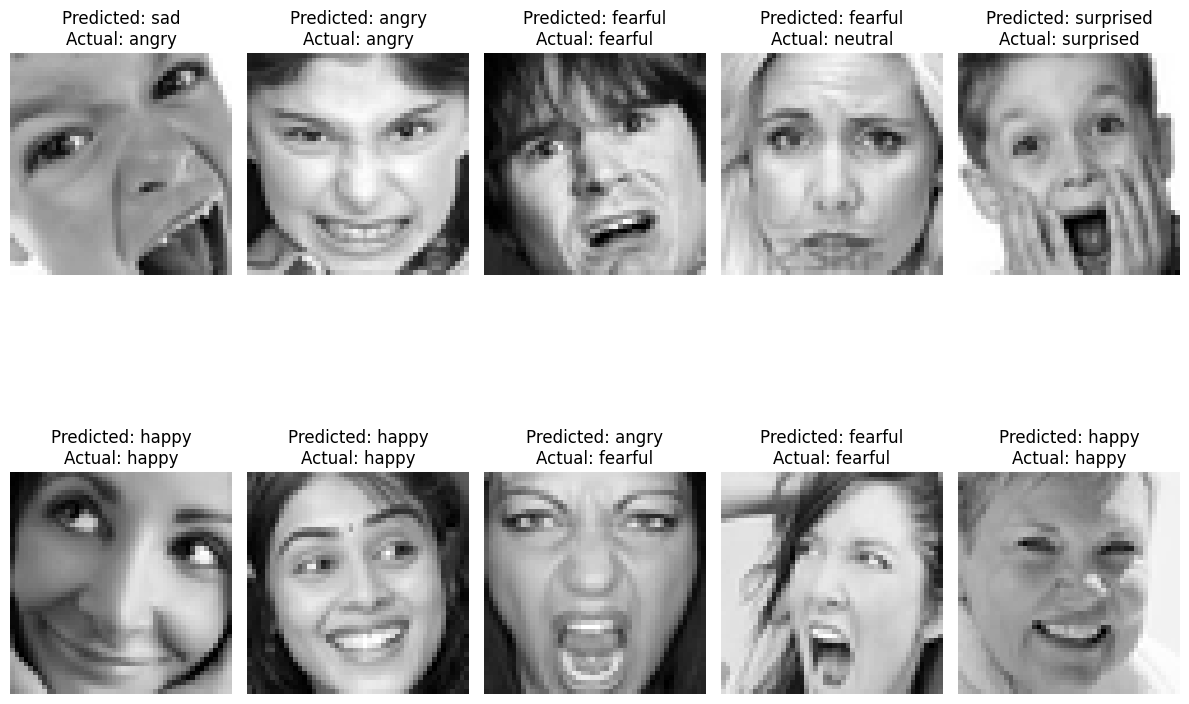

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load a batch of images from the test set
test_imgs, test_labels = next(test_set)

# Predict the labels for the loaded images
predictions = fernet.predict(test_imgs)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_labels, axis=1)


class_labels = list(training_set.class_indices.keys())

# Plot the images with predicted and actual labels
plt.figure(figsize=(12, 10))
for i in range(10):  
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_imgs[i].squeeze(), cmap='gray')
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}\nActual: {class_labels[actual_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

test_loss, test_accu = fernet.evaluate(test_set)






225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6035 - loss: 1.0568
